### CNN on CIFR Assignment:

1.  Please visit this link to access the state-of-art DenseNet code for reference - DenseNet - cifar10 notebook link
2.  You need to create a copy of this and "retrain" this model to achieve 90+ test accuracy. 
3.  You cannot use Dense Layers (also called fully connected layers), or DropOut.
4.  You MUST use Image Augmentation Techniques.
5.  You cannot use an already trained model as a beginning points, you have to initilize as your own
6.  You cannot run the program for more than 300 Epochs, and it should be clear from your log, that you have only used 300 Epochs
7.  You cannot use test images for training the model.
8.  You cannot change the general architecture of DenseNet (which means you must use Dense Block, Transition and Output blocks as mentioned in the code)
9.  You are free to change Convolution types (e.g. from 3x3 normal convolution to Depthwise Separable, etc)
10. You cannot have more than 1 Million parameters in total
11. You are free to move the code from Keras to Tensorflow, Pytorch, MXNET etc. 
12. You can use any optimization algorithm you need. 
13. You can checkpoint your model and retrain the model from that checkpoint so that no need of training the model from first if you lost at any epoch while training. You can directly load that model and Train from that epoch. 

In [21]:
 import keras
 from keras.datasets import cifar10
 from keras.models import Model, Sequential
 from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
 from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
 from keras.layers import Concatenate
 from keras.optimizers import Adam
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten
from tensorflow.keras.optimizers import Adam
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot

In [22]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf

In [23]:
# Hyperparameters
batch_size = 128
num_classes = 10
epochs = 10
l = 8


l = 8
num_filter = 27
#compression = 1
compression =1
dropout_rate = 0.2

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
# Load CIFAR10 Data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

img_height, img_width, channel = X_train.shape[1],X_train.shape[2],X_train.shape[3]

# convert to one hot encoing 
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes) 

In [26]:
y_cv.shape

(10000, 10)

In [27]:
from keras.preprocessing.image import ImageDataGenerator

In [9]:
#creating data for validation
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [14]:
# Dense Block
def denseblock(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    temp = input
    for _ in range(l): 
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_3_3 = layers.Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        #if dropout_rate>0:
         #   Conv2D_3_3 = layers.Dropout(dropout_rate)(Conv2D_3_3)
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

## transition Blosck
def transition(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    #if dropout_rate>0:
     #    Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg

#output layer
def output_layer(input):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(relu)
    flat = layers.Flatten()(AvgPooling)
    output = layers.Dense(num_classes, activation='softmax')(flat)
    return output

In [15]:
#num_filter = 36
#dropout_rate = 0.2
#l = 12
input = layers.Input(shape=(img_height, img_width, channel,))
First_Conv2D = layers.Conv2D(num_filter, (2,2), use_bias=False ,padding='same')(input)

First_Block = denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = transition(First_Block, num_filter, dropout_rate)

Second_Block = denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = transition(Second_Block, num_filter, dropout_rate)

Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition(Third_Block, num_filter, dropout_rate)

Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)

base_model = Model(inputs=[input], outputs=[output])
base_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 27)   324         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 27)   108         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 27)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
base_model.output_shape

(None, 10)

In [ ]:
#removing the last dense layes with flatten
base_model.layers.pop()
model2 = Model(base_model.input, base_model.layers[-3].output)
model2.summary()

Model: "functional_47"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_319 (Conv2D)             (None, 32, 32, 35)   420         input_12[0][0]                   
__________________________________________________________________________________________________
batch_normalization_308 (BatchN (None, 32, 32, 35)   140         conv2d_319[0][0]                 
__________________________________________________________________________________________________
activation_308 (Activation)     (None, 32, 32, 35)   0           batch_normalization_308[0][0]    
______________________________________________________________________________________

In [ ]:
model2.outputs

[<tf.Tensor 'average_pooling2d_47/AvgPool:0' shape=(None, 2, 2, 245) dtype=float32>]

In [ ]:
#adding a con layer at last 
model = models.Sequential()
model.add(model2)
model.add(layers.Conv2D(10,(2,2),strides=[1,1],padding='valid',activation='softmax'))
model.add(layers.Flatten())
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_47 (Functional)   (None, 2, 2, 245)         967925    
_________________________________________________________________
conv2d_347 (Conv2D)          (None, 1, 1, 10)          9810      
_________________________________________________________________
flatten_23 (Flatten)         (None, 10)                0         
Total params: 977,735
Trainable params: 969,895
Non-trainable params: 7,840
_________________________________________________________________


In [ ]:
 model2.output_shape

 

(None, 2, 2, 245)

In [ ]:
# early_stop = EarlyStopping(monitor = "val_loss", patience = 10)

def decay_fn(epoch, lr):
    if epoch < 50:
        return 0.001
    elif epoch >= 50 and epoch < 75:
        return 0.0001
    else:
        return 0.00001

lr_scheduler = LearningRateScheduler(decay_fn)

csv_logger = CSVLogger('training.log')




from keras.callbacks import *
filepath="/content/gdrive/My Drive/MyCNN/epochs:{epoch:03d}-val_accuracy:{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

model.load_weights('/content/gdrive/My Drive/MyCNN/epochs:004-val_accuracy:0.753.hdf5')
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_47 (Functional)   (None, 2, 2, 245)         967925    
_________________________________________________________________
conv2d_347 (Conv2D)          (None, 1, 1, 10)          9810      
_________________________________________________________________
flatten_23 (Flatten)         (None, 10)                0         
Total params: 977,735
Trainable params: 969,895
Non-trainable params: 7,840
_________________________________________________________________


In [ ]:
# test on 10 epochs
history= model.fit(datagen.flow(X_train, y_train, batch_size),
        steps_per_epoch=len(X_train) / batch_size, epochs=10,validation_data=(X_cv, y_cv),callbacks=callbacks_list)

Epoch 1/10
391/390 [==============================] - ETA: 0s - loss: 1.0175 - accuracy: 0.6435
Epoch 00001: val_accuracy improved from -inf to 0.62340, saving model to /content/gdrive/My Drive/MyCNN/epochs:001-val_accuracy:0.623.hdf5
391/390 [==============================] - 132s 338ms/step - loss: 1.0175 - accuracy: 0.6435 - val_loss: 1.1844 - val_accuracy: 0.6234
Epoch 2/10
391/390 [==============================] - ETA: 0s - loss: 0.8754 - accuracy: 0.6932
Epoch 00002: val_accuracy improved from 0.62340 to 0.68460, saving model to /content/gdrive/My Drive/MyCNN/epochs:002-val_accuracy:0.685.hdf5
391/390 [==============================] - 129s 329ms/step - loss: 0.8754 - accuracy: 0.6932 - val_loss: 0.9796 - val_accuracy: 0.6846
Epoch 3/10
391/390 [==============================] - ETA: 0s - loss: 0.8004 - accuracy: 0.7213
Epoch 00003: val_accuracy improved from 0.68460 to 0.71270, saving model to /content/gdrive/My Drive/MyCNN/epochs:003-val_accuracy:0.713.hdf5
391/390 [==========

In [ ]:
X_test=X_test/255

In [ ]:
# Test the model
score = model.evaluate(X_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 3s 11ms/step - loss: 0.7541 - accuracy: 0.7849
Test loss: 0.7541395425796509
Test accuracy: 0.7849000096321106


In [ ]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
import time
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

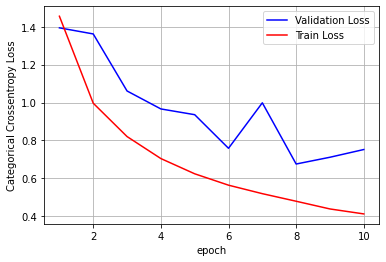

In [ ]:


fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,10+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

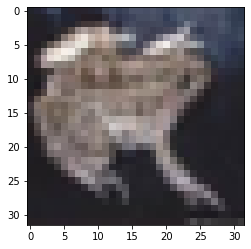

In [ ]:
plt.imshow(X_train[0])

### using image augumentation horizontal vertical shift

In [ ]:
type(X_train[0])

numpy.ndarray

In [28]:
# Reff https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/

def vertical_horizontal_shift(arr_imgs):

      # convert to numpy array
      d_ar = arr_imgs.copy()
      
      for i in tqdm(range(d_ar.shape[0]), position=0):
          data = d_ar[i]
          # expand dimension to one sample
          samples = np.expand_dims(data, 0)
          # create image data augmentation generator
          datagen = ImageDataGenerator(width_shift_range=[-15,15], height_shift_range=[-15,15])
          # prepare iterator
          it = datagen.flow(samples, batch_size=1)
          # generate samples and plot
          # define subplot
          # pyplot.subplot(330 + 1 + i)
          # generate batch of images
          #for j in range(9):
          batch = it.next()     
              #if j == 0:

                  # convert to unsigned integers for viewing
          image = batch[0].astype('uint8')
          d_ar[i] = image
                  # plot raw pixel data
                  #break
      return d_ar

In [31]:
X_train_hor_ver_shift=vertical_horizontal_shift(X_train)
X_cv_hor_ver_shift=vertical_horizontal_shift(X_cv)
X_test_hor_ver_shift=vertical_horizontal_shift(X_test)

100%|██████████| 10000/10000 [00:07<00:00, 1425.08it/s]


In [32]:
# function which activate network and replace last dense layer with conv layer
def modell(X_train,X_cv,X_test,y_train,y_cv,y_test):        # Dense Block
        def denseblock(input, num_filter = 12, dropout_rate = 0.2):
          global compression
          temp = input
          for _ in range(l): 
              BatchNorm = layers.BatchNormalization()(temp)
              relu = layers.Activation('relu')(BatchNorm)
              Conv2D_3_3 = layers.Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
              if dropout_rate>0:
                  Conv2D_3_3 = layers.Dropout(dropout_rate)(Conv2D_3_3)
              concat = layers.Concatenate(axis=-1)([temp,Conv2D_3_3])
              
              temp = concat
              
          return temp

        ## transition Blosck
        def transition(input, num_filter = 12, dropout_rate = 0.2):
          global compression
          BatchNorm = layers.BatchNormalization()(input)
          relu = layers.Activation('relu')(BatchNorm)
          Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
          if dropout_rate>0:
                Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
          avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
          return avg

        #output layer
        def output_layer(input):
          global compression
          BatchNorm = layers.BatchNormalization()(input)
          relu = layers.Activation('relu')(BatchNorm)
          AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(relu)
          flat = layers.Flatten()(AvgPooling)
          output = layers.Dense(num_classes, activation='softmax')(flat)
          return output



          #num_filter = 36
        #dropout_rate = 0.2
        #l = 12
        input = layers.Input(shape=(img_height, img_width, channel,))
        First_Conv2D = layers.Conv2D(num_filter, (2,2), use_bias=False ,padding='same')(input)

        First_Block = denseblock(First_Conv2D, num_filter, dropout_rate)
        First_Transition = transition(First_Block, num_filter, dropout_rate)

        Second_Block = denseblock(First_Transition, num_filter, dropout_rate)
        Second_Transition = transition(Second_Block, num_filter, dropout_rate)

        Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
        Third_Transition = transition(Third_Block, num_filter, dropout_rate)

        Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate)
        output = output_layer(Last_Block)

        base_model = Model(inputs=[input], outputs=[output])
        base_model.summary()
        print("^*"*100)
        print("*************************************after removing last dense layer******************************************")
        print("^*"*100)
        base_model.layers.pop()
        model2 = Model(base_model.input, base_model.layers[-3].output)
        model2.summary()

        print("^*"*100)
        print("**************************************after adding conv2d layer****************************************")

        model = models.Sequential()
        model.add(model2)
        model.add(layers.Conv2D(10,(2,2),strides=[1,1],padding='valid',activation='softmax'))
        model.add(layers.Flatten())
        model.summary()
        print("^*"*100)
        model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
        history= model.fit(X_train, y_train, batch_size,epochs=10,validation_data=(X_cv, y_cv))

        score = model.evaluate(X_test, y_test, verbose=1)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        return model




In [33]:
v_h_shift_model=modell(X_train_hor_ver_shift,X_cv_hor_ver_shift,X_test_hor_ver_shift,y_train,y_cv,y_test)

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 32, 32, 27)   324         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 32, 32, 27)   108         conv2d_36[0][0]                  
__________________________________________________________________________________________________
activation_36 (Activation)      (None, 32, 32, 27)   0           batch_normalization_36[0][0]     
_______________________________________________________________________________________

## Image augumentation horizontal and vertical flip

In [36]:
# Reff https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/

def vertical_horizontal_flip(arr_imgs):

      # convert to numpy array
      d_ar = arr_imgs.copy()
      
      for i in tqdm(range(d_ar.shape[0]), position=0):
          data = d_ar[i]
          # expand dimension to one sample
          samples = np.expand_dims(data, 0)
          # create image data augmentation generator
          datagen = ImageDataGenerator(horizontal_flip=True,vertical_flip=True)
          # prepare iterator
          it = datagen.flow(samples, batch_size=1)
          # generate samples and plot
          # define subplot
          # pyplot.subplot(330 + 1 + i)
          # generate batch of images
          #for j in range(9):
          batch = it.next()     
              #if j == 0:

                  # convert to unsigned integers for viewing
          image = batch[0].astype('uint8')
          d_ar[i] = image
                  # plot raw pixel data
                  #break
      return d_ar

In [37]:
X_train_hor_ver_flip=vertical_horizontal_flip(X_train)
X_cv_hor_ver_flip=vertical_horizontal_flip(X_cv)
X_test_hor_ver_flip=vertical_horizontal_flip(X_test)


100%|██████████| 10000/10000 [00:02<00:00, 4373.36it/s]


In [38]:
v_h_flip_model=modell(X_train_hor_ver_flip,X_cv_hor_ver_flip,X_test_hor_ver_flip,y_train,y_cv,y_test)

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_73 (Conv2D)              (None, 32, 32, 27)   324         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_72 (BatchNo (None, 32, 32, 27)   108         conv2d_73[0][0]                  
__________________________________________________________________________________________________
activation_72 (Activation)      (None, 32, 32, 27)   0           batch_normalization_72[0][0]     
_______________________________________________________________________________________

## image augumentation brightness

In [41]:
# Reff https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/

def brightness(arr_imgs):

      # convert to numpy array
      d_ar = arr_imgs.copy()
      
      for i in tqdm(range(d_ar.shape[0]), position=0):
          data = d_ar[i]
          # expand dimension to one sample
          samples = np.expand_dims(data, 0)
          # create image data augmentation generator
          datagen = ImageDataGenerator(brightness_range=[0.2,1.0])
          # prepare iterator
          it = datagen.flow(samples, batch_size=1)
          # generate samples and plot
          # define subplot
          # pyplot.subplot(330 + 1 + i)
          # generate batch of images
          #for j in range(9):
          batch = it.next()     
              #if j == 0:

                  # convert to unsigned integers for viewing
          image = batch[0].astype('uint8')
          d_ar[i] = image
                  # plot raw pixel data
                  #break
      return d_ar

In [42]:
X_train_bright=brightness(X_train)
X_cv_bright=brightness(X_cv)
X_test_bright=brightness(X_test)

100%|██████████| 10000/10000 [00:04<00:00, 2483.87it/s]


In [43]:
bright_model=modell(X_train_bright,X_cv_bright,X_test_bright,y_train,y_cv,y_test)

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_110 (Conv2D)             (None, 32, 32, 27)   324         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_108 (BatchN (None, 32, 32, 27)   108         conv2d_110[0][0]                 
__________________________________________________________________________________________________
activation_108 (Activation)     (None, 32, 32, 27)   0           batch_normalization_108[0][0]    
______________________________________________________________________________________

## image augumentation featurewise_std_normalization and featurewise_center

In [46]:
# Reff https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/

def stand(arr_imgs):

      # convert to numpy array
      d_ar = arr_imgs.copy()
      
      for i in tqdm(range(d_ar.shape[0]), position=0):
          data = d_ar[i]
          # expand dimension to one sample
          samples =np. expand_dims(data, 0)
          # create image data augmentation generator
          datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
          # prepare iterator
          it = datagen.flow(samples, batch_size=1)
          # generate samples and plot
          # define subplot
          # pyplot.subplot(330 + 1 + i)
          # generate batch of images
          #for j in range(9):
          batch = it.next()     
              #if j == 0:

                  # convert to unsigned integers for viewing
          image = batch[0].astype('uint8')
          d_ar[i] = image
                  # plot raw pixel data
                  #break
      return d_ar

In [47]:
X_train_stand=stand(X_train)
X_cv_stand=stand(X_cv)
X_test_stand=stand(X_test)

  0%|          | 0/50000 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
100%|██████████| 10000/10000 [00:02<00:00, 4306.21it/s]


In [48]:
bright_model=modell(X_train_stand,X_cv_stand,X_test_stand,y_train,y_cv,y_test)

Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_147 (Conv2D)             (None, 32, 32, 27)   324         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_144 (BatchN (None, 32, 32, 27)   108         conv2d_147[0][0]                 
__________________________________________________________________________________________________
activation_144 (Activation)     (None, 32, 32, 27)   0           batch_normalization_144[0][0]    
______________________________________________________________________________________

## image augumentation zoom

In [49]:
# Reff https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/

def zoom(arr_imgs):

      # convert to numpy array
      d_ar = arr_imgs.copy()
      
      for i in tqdm(range(d_ar.shape[0]), position=0):
          data = d_ar[i]
          # expand dimension to one sample
          samples = expand_dims(data, 0)
          # create image data augmentation generator
          datagen = ImageDataGenerator(zoom_range=[0.5,1.0])
          # prepare iterator
          it = datagen.flow(samples, batch_size=1)
          # generate samples and plot
          # define subplot
          # pyplot.subplot(330 + 1 + i)
          # generate batch of images
          #for j in range(9):
          batch = it.next()     
              #if j == 0:

                  # convert to unsigned integers for viewing
          image = batch[0].astype('uint8')
          d_ar[i] = image
                  # plot raw pixel data
                  #break
      return d_ar

In [50]:
X_train_zoom=stand(X_train)
X_cv_zoom=stand(X_cv)
X_test_zoom=stand(X_test)

  0%|          | 0/50000 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
100%|██████████| 10000/10000 [00:02<00:00, 4450.79it/s]


In [51]:
zoom_model=modell(X_train_zoom,X_cv_zoom,X_test_zoom,y_train,y_cv,y_test)

Model: "functional_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_184 (Conv2D)             (None, 32, 32, 27)   324         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_180 (BatchN (None, 32, 32, 27)   108         conv2d_184[0][0]                 
__________________________________________________________________________________________________
activation_180 (Activation)     (None, 32, 32, 27)   0           batch_normalization_180[0][0]    
______________________________________________________________________________________

In [4]:
print("test accuracy without augumentation =", 0.7849000096321106)
print("test_accuracy with shifting =" , 0.5189999938011169)
print("test_accuracy with fliping =" , 0.7170000076293945)
print("test_accuracy with brightness =" , 0.7968000173568726)
print("test_accuracy with standadised =", 0.7972000241279602) 
print("test_accuracy with zoom =", 0.8203999996185303)


test accuracy without augumentation = 0.7849000096321106
test_accuracy with shifting = 0.5189999938011169
test_accuracy with fliping = 0.7170000076293945
test_accuracy with brightness = 0.7968000173568726
test_accuracy with sytandadised = 0.7972000241279602
test_accuracy with zoom = 0.8203999996185303


## Conclusion

- shifting perfrom worst 
- so we can include rest other fliping ,brightness,zoom, standardize


## Hyperparameters
- batch_size = 128
- num_classes = 10
- l = 8
- num_filter = 27
- compression =1
- dropout_rate = 0.2

**for me this configuration perform good as model also dont overfit** 

In [56]:
# activate network as well as replace last dense layer with convet
input = layers.Input(shape=(img_height, img_width, channel,))
First_Conv2D = layers.Conv2D(num_filter, (2,2), use_bias=False ,padding='same')(input)

First_Block = denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = transition(First_Block, num_filter, dropout_rate)

Second_Block = denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = transition(Second_Block, num_filter, dropout_rate)

Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition(Third_Block, num_filter, dropout_rate)

Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)

base_model = Model(inputs=[input], outputs=[output])
base_model.summary()
print("^*"*100)
print("*************************************after removing last dense layer******************************************")
print("^*"*100)
base_model.layers.pop()
model2 = Model(base_model.input, base_model.layers[-3].output)
model2.summary()

print("^*"*100)
print("**************************************after adding conv2d layer****************************************")

model = models.Sequential()
model.add(model2)
model.add(layers.Conv2D(10,(2,2),strides=[1,1],padding='valid',activation='softmax'))
model.add(layers.Flatten())
model.summary()
print("^*"*100)

Model: "functional_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_221 (Conv2D)             (None, 32, 32, 27)   324         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_216 (BatchN (None, 32, 32, 27)   108         conv2d_221[0][0]                 
__________________________________________________________________________________________________
activation_216 (Activation)     (None, 32, 32, 27)   0           batch_normalization_216[0][0]    
______________________________________________________________________________________

In [52]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    
    
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.2,1.0],zoom_range=[0.5,1.0])

In [53]:
from google.colab import drive

drive.mount('/content/gdrive',force_remount=True)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [54]:
from keras.callbacks import ModelCheckpoint,LearningRateScheduler,CSVLogger, Callback,ReduceLROnPlateau

In [55]:
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 5, min_lr = 0.000001)

          # early_stop = EarlyStopping(monitor = "val_loss", patience = 10)

def decay_fn(epoch, lr):
      if epoch < 50:
          return 0.001
      elif epoch >= 50 and epoch < 75:
          return 0.0001
      else:
          return 0.00001

lr_scheduler = LearningRateScheduler(decay_fn)

csv_logger = CSVLogger('training.log')
filepath="/content/drive/My Drive/MyCNN/model-{epoch:03d}-{accuracy:03f}-{val_accuracy:03f}.h5'"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True,mode='auto')
callbacks_list = [checkpoint]

In [57]:
          model.compile(loss='categorical_crossentropy',
                        optimizer=Adam(),
                        metrics=['accuracy'])

In [58]:
          model.fit_generator(
            datagen.flow(X_train, y_train, batch_size=128),
            steps_per_epoch=(len(X_train)/batch_size),              
            epochs=300,
            verbose = 1,
            validation_data=(X_cv, y_cv),callbacks=[checkpoint])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/300


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


391/390 [==============================] - ETA: 0s - loss: 1.7734 - accuracy: 0.3477
Epoch 00001: val_accuracy improved from -inf to 0.37620, saving model to /content/drive/My Drive/MyCNN/model-001-0.347740-0.376200.h5'
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/MyCNN/model-001-0.347740-0.376200.h5'/assets
391/390 [==============================] - 82s 211ms/step - loss: 1.7734 - accuracy: 0.3477 - val_loss: 1.7534 - val_accuracy: 0.3762
Epoch 2/300
391/390 [==============================] - ETA: 0s - loss: 1.3891 - accuracy: 0.5017
Epoch 00002: val_accuracy improved from 0.37620 to 0.47610, saving model to /content/drive/My Drive/MyCNN/model-002-0.501660-0.476100.h5'
INFO:tensorflow:Assets written to: /content/drive/My Drive/MyCNN/model-00

In [ ]:
model.load_weights('/content/drive/My Drive/MyCNN/model-142-0.941420-0.927900.h5')
model.compile(loss='categorical_crossentropy',
                        optimizer=Adam(),
                        metrics=['accuracy'])

In [59]:
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


313/313 [==============================] - 3s 11ms/step - loss: 0.2198 - accuracy: 0.9327
Test loss: 0.2197745144367218
Test accuracy: 0.932699978351593


## RESULT
- my intention was to run this till 300 epochs
- due to colab time limit I able to train till 150 epochs but still able to achieve the **test accuracy=0.932699978351593**
- **Total params: 993,961**

#### Hyperparameters
- batch_size = 128
- num_classes = 10
- l = 8
- num_filter = 27
- compression =1
- dropout_rate = 0.2